In [1]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 6.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader, Subset
from collections import Counter
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold


In [3]:
BBBP_dataset = pd.read_csv('BBBP.csv')
# BBBP_dataset.head(5)

Lengths of SMILES strings:
[32, 40, 50, 32, 66, 92, 95, 35, 57, 28, 47, 45, 7, 87, 38, 49, 58, 38, 58, 28, 8, 18, 53, 46, 42, 28, 38, 40, 30, 88, 29, 53, 39, 46, 38, 27, 27, 38, 48, 33, 47, 54, 26, 19, 48, 37, 49, 67, 19, 43, 55, 12, 27, 144, 42, 36, 54, 37, 16, 42, 54, 40, 146, 46, 68, 50, 31, 33, 46, 77, 40, 8, 17, 33, 33, 43, 63, 39, 36, 34, 34, 18, 30, 30, 30, 30, 78, 34, 33, 36, 51, 26, 12, 47, 11, 45, 58, 29, 54, 18, 21, 18, 57, 58, 48, 71, 62, 60, 68, 33, 36, 57, 54, 32, 23, 46, 18, 109, 38, 34, 44, 19, 72, 32, 85, 50, 34, 102, 86, 63, 33, 34, 70, 59, 30, 47, 33, 40, 29, 28, 26, 30, 18, 43, 20, 44, 64, 47, 59, 44, 39, 33, 91, 44, 28, 26, 38, 73, 73, 57, 55, 44, 45, 40, 70, 26, 26, 31, 28, 29, 256, 89, 37, 31, 41, 12, 64, 7, 17, 33, 84, 43, 33, 35, 182, 189, 51, 30, 39, 21, 27, 12, 44, 110, 105, 31, 58, 48, 19, 170, 239, 29, 50, 111, 97, 17, 97, 96, 35, 39, 89, 27, 25, 174, 54, 21, 38, 36, 47, 51, 39, 35, 55, 34, 43, 30, 60, 33, 52, 47, 54, 50, 36, 58, 36, 43, 69, 16, 41, 30, 49,

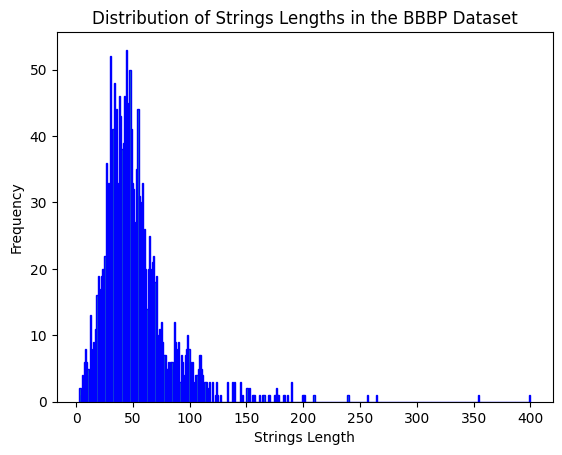

In [4]:
# در این بخش آمدم طول رشته ها را بر اساس تعداد کارکتر بدست آوردم و توزیع آن را رسم کردم
smiles_lengths = []
for smiles_str in BBBP_dataset["smiles"]:
    smiles_length = len(smiles_str)
    smiles_lengths.append(smiles_length)

print("Lengths of SMILES strings:")
print(smiles_lengths)
# print(max(smiles_lengths))
max_length = max(smiles_lengths)
min_length = min(smiles_lengths)
print(f"Min Length: {min_length}, Max Length: {max_length}")
plt.hist(smiles_lengths, bins=range(min_length, max_length + 1), edgecolor='blue')
plt.xlabel('Strings Length')
plt.ylabel('Frequency')
plt.title('Distribution of Strings Lengths in the BBBP Dataset')
plt.show()

[20:21:57] Explicit valence for atom # 1 N, 4, is greater than permitted
[20:21:57] WARNING: not removing hydrogen atom without neighbors
[20:21:57] Explicit valence for atom # 6 N, 4, is greater than permitted
[20:21:57] WARNING: not removing hydrogen atom without neighbors
[20:21:58] WARNING: not removing hydrogen atom without neighbors
[20:21:58] WARNING: not removing hydrogen atom without neighbors
[20:21:58] WARNING: not removing hydrogen atom without neighbors
[20:21:58] WARNING: not removing hydrogen atom without neighbors
[20:21:58] WARNING: not removing hydrogen atom without neighbors
[20:21:58] Explicit valence for atom # 6 N, 4, is greater than permitted
[20:21:58] WARNING: not removing hydrogen atom without neighbors
[20:21:58] WARNING: not removing hydrogen atom without neighbors
[20:21:58] WARNING: not removing hydrogen atom without neighbors
[20:21:58] WARNING: not removing hydrogen atom without neighbors
[20:21:58] Explicit valence for atom # 11 N, 4, is greater than pe

Token frequency: Counter({'': 48868, 'C': 36596, 'O': 6254, 'N': 4391, '=': 3872, 'Cl': 618, 'S': 570, 'F': 509, '-': 132, 'Br': 50, '#': 49, 'H': 40, 'Na': 21, 'P': 11, 'I': 6, 'Ca': 1, 'B': 1})
Min Chain Length: 2, Max Chain Length: 132


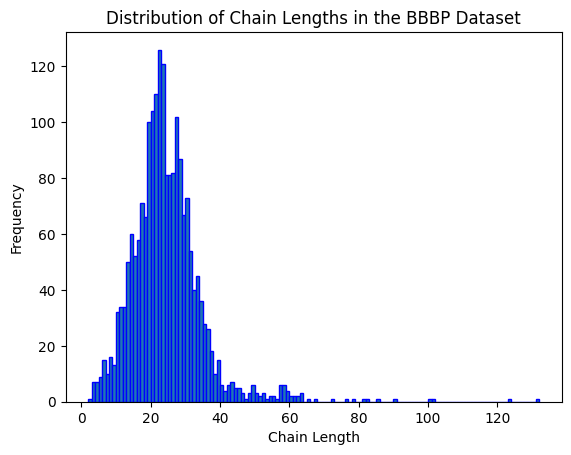

In [5]:
# در این بخش آمدم با استفاده از کتابخانه آماده به بررسی توکن های موجود در رشته ها پرداختم
# در این قسمت تنوع توکن ها و فرکانس آن ها را نیز خروجی گرفتم
# دقت شود در این قسمت با استفاده از کتابخانه rdkit به بررسی رشته ها پرداختم
# توکنایز کردن رشته ها با استفاده از توابع این کتابخانه انجام شده است .
def tokens(mol):
    if mol is not None:
        atoms = [atom.GetSymbol() for atom in mol.GetAtoms()]
        bonds = [bond.GetSmarts() for bond in mol.GetBonds()]
        return atoms + bonds
    else:
        return []

BBBP_dataset['molecular chain rdkit'] = BBBP_dataset['smiles'].apply(Chem.MolFromSmiles)
BBBP_dataset['molecular chain Length'] = BBBP_dataset['molecular chain rdkit'].apply(lambda x: x.GetNumAtoms() if x is not None else None)
BBBP_dataset['Tokens'] = BBBP_dataset['molecular chain rdkit'].apply(tokens)
# BBBP_dataset.head(4)
all_tokens = []
for tokens_list in BBBP_dataset['Tokens']:
    for token in tokens_list:
        all_tokens.append(token)
token_frequency = Counter(all_tokens)
print(f"Token frequency: {token_frequency}")

min_length = round(BBBP_dataset['molecular chain Length'].min())
max_length = round(BBBP_dataset['molecular chain Length'].max())
print(f"Min Chain Length: {min_length}, Max Chain Length: {max_length}")
plt.hist(BBBP_dataset['molecular chain Length'], bins=range(min_length, max_length + 1), edgecolor='blue')
plt.xlabel('Chain Length')
plt.ylabel('Frequency')
plt.title('Distribution of Chain Lengths in the BBBP Dataset')
plt.show()



The simplified molecular-input line-entry system (SMILES) is a specification in the form of a line notation for describing the structure of chemical species using short ASCII strings. SMILES strings can be imported by most molecule editors for conversion back into two-dimensional drawings or three-dimensional models of the molecules. (source:  Wikipedia)

Key Features:

Atoms:

Represented by elemental symbols (e.g., C for carbon, O for oxygen).
Hydrogens are often implicit and are assumed to fill the valency of the atom.

Bonds:

Single bonds are implicit and can be omitted.
Double bonds are represented by '='.
Triple bonds are represented by '#'.

Branching:

Parentheses '(' and ')' are used for branching and indicating the order of connectivity.

Ring Structures:

Ring structures are indicated by numbers (e.g., 'C1CCCCC1' represents a cyclohexane ring).

Isomerism:

Stereoisomerism is represented using '/', '' for cis-trans isomerism.
(source: chatgpt)

In [ ]:
# با توجه به خروجی های گرفته شده برای قسمت اول سوال می توان گفت توزیع طول رشته های موجود در دیتاست
# تقریبا شبیه توزیع نرمال می باشد و تراکم بیشتر در بازه 25 تا 60 برای نمودار اول که بر اساس تعداد کاراکتر رسم شد
# و تراکم بیشتر در بازه 20 تا 30 برای رشته های تبدیل شده به فرمت rdkit
# می باشد.

In [6]:
strings = BBBP_dataset['smiles']

all_smiles_concatenated = ''.join(strings)
unique_chars = sorted(set(all_smiles_concatenated))
# print(unique_chars)

# Function defined to create one-hot encoded matrix
def smiles_encoder(smiles, max_len, unique_char):
    idx = {char: index for index, char in enumerate(unique_char)}
    smiles_matrix = np.zeros((len(unique_char), max_len))
    for index, char in enumerate(smiles):
        smiles_matrix[idx[char], index] = 1
    return smiles_matrix

max_len = max(len(smiles) for smiles in strings)
# print(max_len)
BBBP_dataset['encoded_matrix'] = BBBP_dataset['smiles'].apply(lambda x: smiles_encoder(x, max_len, unique_chars))

sample = BBBP_dataset['encoded_matrix'].iloc[10].shape
print(sample)
# print("One-Hot Encoded Matrix for the first sample:")
# print(first_sample_encoded_matrix)

(39, 400)


In [7]:
X = np.stack(BBBP_dataset['encoded_matrix'].values)
y = BBBP_dataset['p_np'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(X.shape)
# print(X.shape)
print(X_train.shape)

(1640, 39, 400)


In [8]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 10
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(X_train_tensor.shape)
for inputs, labels in train_loader:
  # print(inputs)
  print(inputs.shape)
  print(labels)
  print(labels.shape)

  break

torch.Size([1640, 39, 400])
torch.Size([10, 39, 400])
tensor([1., 1., 1., 1., 1., 1., 0., 1., 1., 1.])
torch.Size([10])


In [9]:
class Fully_Connected(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(Fully_Connected, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [10]:
input_size = 15600
hidden_size1 = 800
hidden_size2 = 50
model = Fully_Connected(input_size, hidden_size1, hidden_size2)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = outputs.transpose(0, 1).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

model.eval()
with torch.no_grad():
    all_labels = []
    all_probs = []
    correct = 0
    total = 0

    for inputs, labels in test_loader:
        outputs = model(inputs)
        outputs = outputs.squeeze()

        probs = torch.sigmoid(outputs)
        all_probs.extend(probs.cpu().numpy())
        true_labels = labels.cpu().numpy()
        all_labels.extend(true_labels)

        predicted = (probs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

roc_auc = roc_auc_score(all_labels, all_probs)
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2%}")
print(f"ROC-AUC Score: {roc_auc:.2%}")

Test Accuracy: 79.27%
ROC-AUC Score: 93.04%


In [11]:
# Save the trained model
torch.save(model.state_dict(), 'trained_FC_model.pth')

In [12]:
class LSTM_BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, layer_size, output_size, bidirectional):
        super(LSTM_BiLSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.layer_size = layer_size
        self.output_size = output_size
        self.bidirectional = bidirectional

        self.lstm = nn.LSTM(input_size, hidden_size, layer_size, batch_first=True, bidirectional=bidirectional)
        if bidirectional:
            self.layer = nn.Linear(hidden_size*2, output_size)
        else:
            self.layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        if self.bidirectional:
            hidden_state = torch.zeros(self.layer_size*2, x.size(0), self.hidden_size)
            cell_state = torch.zeros(self.layer_size*2, x.size(0), self.hidden_size)
        else:
            hidden_state = torch.zeros(self.layer_size, x.size(0), self.hidden_size)
            cell_state = torch.zeros(self.layer_size, x.size(0), self.hidden_size)
        output, (last_hidden_state, last_cell_state) = self.lstm(x, (hidden_state, cell_state))
        # output = output[:, -1, :]
        # Use the last hidden state as the representation
        output = output[:, -1, :]
        output = self.layer(output)
        output = torch.sigmoid(output)
        return output

In [13]:
batch_size = 10
input_size = 400
hidden_size = 128
layer_size = 2
output_size = 1

In [15]:
# LSTM
lstm_model = LSTM_BiLSTM(input_size, hidden_size, layer_size, output_size, bidirectional=False)
criterion = nn.BCELoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=0.001)

# Training loop for  LSTM
num_epochs = 6
for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    for inputs, labels in train_loader:
        optimizer_lstm.zero_grad()
        outputs = lstm_model(inputs)
        outputs = outputs.squeeze()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_lstm.step()
        total_loss += loss.item()
        predicted_binary = (outputs > 0.5).float()
        total_correct += (predicted_binary == labels).sum().item()
        total_samples += labels.size(0)
    average_loss = total_loss / len(train_loader)
    train_accuracy = total_correct / total_samples
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

# Testing loop after training
lstm_model.eval()
total_loss_test = 0
total_correct_test = 0
total_samples_test = 0
all_labels_test = []
all_predictions_test = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs_test = lstm_model(inputs)
        outputs_test = outputs_test.squeeze()
        loss_test = criterion(outputs_test, labels)
        total_loss_test += loss_test.item()
        predicted_binary_test = (outputs_test > 0.5).float()
        total_correct_test += (predicted_binary_test == labels).sum().item()
        total_samples_test += labels.size(0)
        all_labels_test.extend(labels.numpy())
        all_predictions_test.extend(torch.sigmoid(outputs_test).numpy())
average_loss_test = total_loss_test / len(test_loader)
test_accuracy = total_correct_test / total_samples_test
roc_auc_test = roc_auc_score(all_labels_test, all_predictions_test)
print(f"Test Loss: {average_loss_test:.4f}, Test Accuracy: {test_accuracy:.4f}, ROC AUC: {roc_auc_test:.4f}")

Epoch 1/6, Loss: 0.4554, Train Accuracy: 0.7890
Epoch 2/6, Loss: 0.3376, Train Accuracy: 0.8482
Epoch 3/6, Loss: 0.2829, Train Accuracy: 0.8750
Epoch 4/6, Loss: 0.2521, Train Accuracy: 0.8835
Epoch 5/6, Loss: 0.2445, Train Accuracy: 0.8854
Epoch 6/6, Loss: 0.2260, Train Accuracy: 0.9018
Test Loss: 0.3231, Test Accuracy: 0.8463, ROC AUC: 0.9161


In [16]:
# BiLSTM
bidirectional_lstm_model = LSTM_BiLSTM(input_size, hidden_size, layer_size, output_size, bidirectional=True)
criterion1 = nn.BCELoss()
optimizer_bidirectional_lstm = optim.Adam(bidirectional_lstm_model.parameters(), lr=0.001)

# Training loop for Bidirectional LSTM
num_epochs = 6
for epoch in range(num_epochs):
    bidirectional_lstm_model.train()
    total_loss1 = 0
    total_correct1 = 0
    total_samples1 = 0
    for inputs, labels in train_loader:
        optimizer_bidirectional_lstm.zero_grad()
        outputs1 = bidirectional_lstm_model(inputs)
        outputs1 = outputs1.squeeze()
        loss1 = criterion1(outputs1, labels)
        loss1.backward()
        optimizer_bidirectional_lstm.step()
        total_loss1 += loss1.item()
        predicted_binary1 = (outputs1 > 0.5).float()
        total_correct1 += (predicted_binary1 == labels).sum().item()
        total_samples1 += labels.size(0)
    average_loss1 = total_loss1 / len(train_loader)
    train_accuracy1 = total_correct1 / total_samples1
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss1:.4f}, Train Accuracy: {train_accuracy1:.4f}")

# Testing loop after training
bidirectional_lstm_model.eval()
total_loss_test1 = 0
total_correct_test1 = 0
total_samples_test1 = 0
all_labels_test1 = []
all_predictions_test1 = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs_test1 = bidirectional_lstm_model(inputs)
        outputs_test1 = outputs_test1.squeeze()
        loss_test1 = criterion(outputs_test1, labels)
        total_loss_test1 += loss_test1.item()
        predicted_binary_test1 = (outputs_test1 > 0.5).float()
        total_correct_test1 += (predicted_binary_test1 == labels).sum().item()
        total_samples_test1 += labels.size(0)
        all_labels_test1.extend(labels.numpy())
        all_predictions_test1.extend(torch.sigmoid(outputs_test1).numpy())
average_loss_test1 = total_loss_test1 / len(test_loader)
test_accuracy1 = total_correct_test1 / total_samples_test1
roc_auc_test1 = roc_auc_score(all_labels_test1, all_predictions_test1)
print(f"Test Loss: {average_loss_test1:.4f}, Test Accuracy: {test_accuracy1:.4f}, ROC AUC: {roc_auc_test1:.4f}")


Epoch 1/6, Loss: 0.5081, Train Accuracy: 0.7799
Epoch 2/6, Loss: 0.3941, Train Accuracy: 0.8378
Epoch 3/6, Loss: 0.3072, Train Accuracy: 0.8665
Epoch 4/6, Loss: 0.2782, Train Accuracy: 0.8841
Epoch 5/6, Loss: 0.2572, Train Accuracy: 0.8841
Epoch 6/6, Loss: 0.2296, Train Accuracy: 0.9006
Test Loss: 0.3180, Test Accuracy: 0.8537, ROC AUC: 0.9118


In [17]:
# Save the LSTM model
torch.save(lstm_model.state_dict(), 'trained_lstm_model.pth')
# Save the BiLSTM model
torch.save(bidirectional_lstm_model.state_dict(), 'trained_bilstm_model.pth')

In [18]:
a = np.stack(BBBP_dataset['encoded_matrix'].values)
b = BBBP_dataset['p_np'].values
a_tensor = torch.tensor(a, dtype=torch.float32)
b_tensor = torch.tensor(b, dtype=torch.float32)
full_dataset = TensorDataset(a_tensor, b_tensor)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
fold_datasets = []
for fold, (train_index, test_index) in enumerate(skf.split(a, b)):
    fold_train_dataset = torch.utils.data.Subset(full_dataset, train_index)
    fold_test_dataset = torch.utils.data.Subset(full_dataset, test_index)
    fold_datasets.append((fold_train_dataset, fold_test_dataset))

In [19]:
# cross validation for Lstm
all_test_accuracies2 = []
all_roc_auc_scores2 = []
for fold, (fold_train_dataset, fold_test_dataset) in enumerate(fold_datasets):
    batch_size = 10
    fold_train_loader = DataLoader(fold_train_dataset, batch_size=batch_size, shuffle=True)
    fold_test_loader = DataLoader(fold_test_dataset, batch_size=batch_size, shuffle=False)
    lstm_model1 = LSTM_BiLSTM(input_size, hidden_size, layer_size, output_size, bidirectional=False)
    criterion2 = nn.BCELoss()
    optimizer_lstm2 = optim.Adam(lstm_model1.parameters(), lr=0.001)
    num_epochs = 6
    print(f"Fold {fold + 1}/{num_folds}")
    for epoch in range(num_epochs):
       lstm_model1.train()
       total_loss2 = 0
       total_correct2 = 0
       total_samples2 = 0
       for inputs, labels in fold_train_loader:
          optimizer_lstm2.zero_grad()
          outputs2 = lstm_model1(inputs)
          outputs2 = outputs2.squeeze()
          loss2 = criterion2(outputs2, labels)
          loss2.backward()
          optimizer_lstm2.step()
          total_loss2 += loss2.item()
          predicted_binary2 = (outputs2 > 0.5).float()
          total_correct2 += (predicted_binary2 == labels).sum().item()
          total_samples2 += labels.size(0)
       average_loss2 = total_loss2 / len(train_loader)
       train_accuracy2 = total_correct2 / total_samples2
       print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss2:.4f}, Train Accuracy: {train_accuracy2:.4f}")
    lstm_model1.eval()
    total_loss_test2 = 0
    total_correct_test2 = 0
    total_samples_test2 = 0
    all_labels_test2 = []
    all_predictions_test2 = []
    with torch.no_grad():
        for inputs, labels in fold_test_loader:
           outputs_test2 = lstm_model1(inputs)
           outputs_test2 = outputs_test2.squeeze()
           loss_test2 = criterion2(outputs_test2, labels)
           total_loss_test2 += loss_test2.item()
           predicted_binary_test2 = (outputs_test2 > 0.5).float()
           total_correct_test2 += (predicted_binary_test2 == labels).sum().item()
           total_samples_test2 += labels.size(0)
           all_labels_test2.extend(labels.numpy())
           all_predictions_test2.extend(torch.sigmoid(outputs_test2).numpy())
    average_loss_test2 = total_loss_test2 / len(test_loader)
    test_accuracy2 = total_correct_test2 / total_samples_test2
    roc_auc_test2 = roc_auc_score(all_labels_test2, all_predictions_test2)
    print(f"Test Loss: {average_loss_test2:.4f}, Test Accuracy: {test_accuracy2:.4f}, ROC AUC: {roc_auc_test2:.4f}")
    all_test_accuracies2.append(test_accuracy2)
    all_roc_auc_scores2.append(roc_auc_test2)


mean_accuracy = np.mean(all_test_accuracies2)
std_accuracy = np.std(all_test_accuracies2)
mean_roc_auc = np.mean(all_roc_auc_scores2)
std_roc_auc = np.std(all_roc_auc_scores2)
print(f"\nOverall Performance:")
print(f"Mean Test Accuracy: {mean_accuracy:.4f} +/- {std_accuracy:.4f}")
print(f"Mean ROC AUC: {mean_roc_auc:.4f} +/- {std_roc_auc:.4f}")

Fold 1/5
Epoch 1/6, Loss: 0.5032, Train Accuracy: 0.7890
Epoch 2/6, Loss: 0.3638, Train Accuracy: 0.8341
Epoch 3/6, Loss: 0.3071, Train Accuracy: 0.8604
Epoch 4/6, Loss: 0.2698, Train Accuracy: 0.8762
Epoch 5/6, Loss: 0.2393, Train Accuracy: 0.8915
Epoch 6/6, Loss: 0.2228, Train Accuracy: 0.9000
Test Loss: 0.3442, Test Accuracy: 0.8415, ROC AUC: 0.9086
Fold 2/5
Epoch 1/6, Loss: 0.4668, Train Accuracy: 0.8037
Epoch 2/6, Loss: 0.3387, Train Accuracy: 0.8409
Epoch 3/6, Loss: 0.2920, Train Accuracy: 0.8591
Epoch 4/6, Loss: 0.2625, Train Accuracy: 0.8835
Epoch 5/6, Loss: 0.2479, Train Accuracy: 0.8915
Epoch 6/6, Loss: 0.2459, Train Accuracy: 0.8921
Test Loss: 0.3206, Test Accuracy: 0.8634, ROC AUC: 0.9033
Fold 3/5
Epoch 1/6, Loss: 0.4694, Train Accuracy: 0.7909
Epoch 2/6, Loss: 0.3653, Train Accuracy: 0.8366
Epoch 3/6, Loss: 0.3098, Train Accuracy: 0.8634
Epoch 4/6, Loss: 0.2686, Train Accuracy: 0.8896
Epoch 5/6, Loss: 0.2754, Train Accuracy: 0.8841
Epoch 6/6, Loss: 0.2590, Train Accuracy: 

In [20]:
# Save the LSTM model
torch.save(lstm_model1.state_dict(), 'trained_lstm_model_CV.pth')

In [21]:
# cross validation for biLstm
all_test_accuracies3 = []
all_roc_auc_scores3 = []
for fold, (fold_train_dataset, fold_test_dataset) in enumerate(fold_datasets):
    batch_size = 10
    fold_train_loader = DataLoader(fold_train_dataset, batch_size=batch_size, shuffle=True)
    fold_test_loader = DataLoader(fold_test_dataset, batch_size=batch_size, shuffle=False)
    bidirectional_lstm_model1 = LSTM_BiLSTM(input_size, hidden_size, layer_size, output_size, bidirectional=True)
    criterion3 = nn.BCELoss()
    optimizer_lstm3 = optim.Adam(bidirectional_lstm_model1.parameters(), lr=0.001)
    num_epochs = 6
    print(f"Fold {fold + 1}/{num_folds}")
    for epoch in range(num_epochs):
       bidirectional_lstm_model1.train()
       total_loss3 = 0
       total_correct3 = 0
       total_samples3 = 0
       for inputs, labels in fold_train_loader:
          optimizer_lstm3.zero_grad()
          outputs3 = bidirectional_lstm_model1(inputs)
          outputs3 = outputs3.squeeze()
          loss3 = criterion(outputs3, labels)
          loss3.backward()
          optimizer_lstm3.step()
          total_loss3 += loss3.item()
          predicted_binary3 = (outputs3 > 0.5).float()
          total_correct3 += (predicted_binary3 == labels).sum().item()
          total_samples3 += labels.size(0)
       average_loss3 = total_loss3 / len(train_loader)
       train_accuracy3 = total_correct3 / total_samples3
       print(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss3:.4f}, Train Accuracy: {train_accuracy3:.4f}")
    bidirectional_lstm_model1.eval()
    total_loss_test3 = 0
    total_correct_test3 = 0
    total_samples_test3 = 0
    all_labels_test3 = []
    all_predictions_test3 = []
    with torch.no_grad():
        for inputs, labels in fold_test_loader:
           outputs_test3 = bidirectional_lstm_model1(inputs)
           outputs_test3 = outputs_test3.squeeze()
           loss_test3 = criterion3(outputs_test3, labels)
           total_loss_test3 += loss_test3.item()
           predicted_binary_test3 = (outputs_test3 > 0.5).float()
           total_correct_test3 += (predicted_binary_test3 == labels).sum().item()
           total_samples_test3 += labels.size(0)
           all_labels_test3.extend(labels.numpy())
           all_predictions_test3.extend(torch.sigmoid(outputs_test3).numpy())
    average_loss_test3 = total_loss_test3 / len(test_loader)
    test_accuracy3 = total_correct_test3 / total_samples_test3
    roc_auc_test3 = roc_auc_score(all_labels_test3, all_predictions_test3)
    print(f"Test Loss: {average_loss_test3:.4f}, Test Accuracy: {test_accuracy3:.4f}, ROC AUC: {roc_auc_test3:.4f}")
    all_test_accuracies3.append(test_accuracy3)
    all_roc_auc_scores3.append(roc_auc_test3)


mean_accuracy1 = np.mean(all_test_accuracies3)
std_accuracy1 = np.std(all_test_accuracies3)
mean_roc_auc1 = np.mean(all_roc_auc_scores3)
std_roc_auc1 = np.std(all_roc_auc_scores3)
print(f"\nOverall Performance:")
print(f"Mean Test Accuracy: {mean_accuracy1:.4f} +/- {std_accuracy1:.4f}")
print(f"Mean ROC AUC: {mean_roc_auc1:.4f} +/- {std_roc_auc1:.4f}")

Fold 1/5
Epoch 1/6, Loss: 0.4970, Train Accuracy: 0.7872
Epoch 2/6, Loss: 0.3629, Train Accuracy: 0.8396
Epoch 3/6, Loss: 0.2913, Train Accuracy: 0.8750
Epoch 4/6, Loss: 0.2571, Train Accuracy: 0.8768
Epoch 5/6, Loss: 0.2462, Train Accuracy: 0.8915
Epoch 6/6, Loss: 0.2298, Train Accuracy: 0.8976
Test Loss: 0.3377, Test Accuracy: 0.8488, ROC AUC: 0.9167
Fold 2/5
Epoch 1/6, Loss: 0.4846, Train Accuracy: 0.7793
Epoch 2/6, Loss: 0.3389, Train Accuracy: 0.8439
Epoch 3/6, Loss: 0.3058, Train Accuracy: 0.8720
Epoch 4/6, Loss: 0.2570, Train Accuracy: 0.8884
Epoch 5/6, Loss: 0.2412, Train Accuracy: 0.8982
Epoch 6/6, Loss: 0.2372, Train Accuracy: 0.8982
Test Loss: 0.3546, Test Accuracy: 0.8537, ROC AUC: 0.8931
Fold 3/5
Epoch 1/6, Loss: 0.4901, Train Accuracy: 0.7872
Epoch 2/6, Loss: 0.3586, Train Accuracy: 0.8415
Epoch 3/6, Loss: 0.3177, Train Accuracy: 0.8683
Epoch 4/6, Loss: 0.2957, Train Accuracy: 0.8732
Epoch 5/6, Loss: 0.2659, Train Accuracy: 0.8902
Epoch 6/6, Loss: 0.2521, Train Accuracy: 

In [22]:
# Save the LSTM model
torch.save(lstm_model.state_dict(), 'trained_bilstm_model_CV.pth')

In [23]:
# با توجه به دقت های بدست آمده مشاهده می شود که عملکرد دو مدل بازگشتی تقریبا مشابه هم می باشد ولی عملکرد مدل
# Lstm
# بهتر بوده است و کمی نتایج بهتری رقم خورده است. البته عملکرد دو مدل بستگی به نوع دیتاست دارد. دیتاست ما
# حاوی رشته های مولکول  می باشد و بسته به اینکه ترتیب و یا الگو خاصی در دیتاست باشد
# می توان بهترین مدل را انتخاب کرد
# همچنین باید توجه داشت هزینه محاسباتی در مدل دوم یعنی
# BiLstm
# نسبت به اولی بیشتر می باشد. باید توجه داشت در مدل دوم دو مسیر داریم
#(one forward through time 1→t and one backward through time t→1)
# بنابراین در این مسئله و با توجه به رشته ها مولکولی مشاهده شد که مدل اول بهتر عمل کرد.
